# Quiz 2

# TABLE OF CONTENTS

* [1. SETUP](#section-one)
    - [1.1 Importing Libraries](#subsection-one-one)
    - [1.2 Importing 'train.csv' dataset](#subsection-one-two)
    - [1.3 Data cleaning](#subsection-one-three)
    - [1.4 Text Preprocessing](#subsection-one-four)
    - [1.6 Train/Test Split](#subsection-one-six)


* [2. MODEL TRAINING AND TESTING](#section-two)
    - [2.1 Logistic Regression Classifier](#subsection-two-one)
    - [2.2 Naive Bayes Classifier](#subsection-two-two)
    - [2.3 Random Forest Classifier](#subsection-two-three)
    - [2.4 Extreme Gradient Boosting (XGBoost) Classifier](#subsection-two-four)


* [3. MODEL EVALUATION](#section-three)
    - [3.1 ROC and AUC](#subsection-three-one)
    - [3.2 Confusion Matrix](#subsection-three-two)
    - [3.3 Classification reports and accuracy score](#subsection-three-three)
    - [3.4 Model evaluation and Conclusion](#subsection-three-four)


* [4. SAVING THE MODEL AND EXECUTING PREDICTION ON "data_test.csv"](#section-four)
    - [4.1 Saving our model as a pickle object in Python](#subsection-four-one)
    - [4.2 Importing, pre-processing and vectorizing review text from "data_test.csv"](#subsection-four-two)
    - [4.3 Applying the trained XGBoost model](#subsection-four-three)
    - [4.4 Saving the labelled test data for submission](#subsection-four-four)

<a id="section-one"></a>
# 1. SETUP

<a id="subsection-one-one"></a>
## 1.1 Importing Libraries

Execute the following script to import the required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
from sklearn.datasets import load_files
nltk.download('stopwords')
from nltk.corpus import stopwords

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Bryon
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="subsection-one-two"></a>
## 1.2 Importing 'train.csv' dataset

I will use the read_csv function from the pandas library to import the dataset.

In [2]:
review_data = pd.read_csv('data_train.csv')
X, y = review_data.review_body, review_data.label

<a id="subsection-one-three"></a>
## 1.3 Data Cleaning
### Handling missing data

In [3]:
import missingno as msno

<AxesSubplot:>

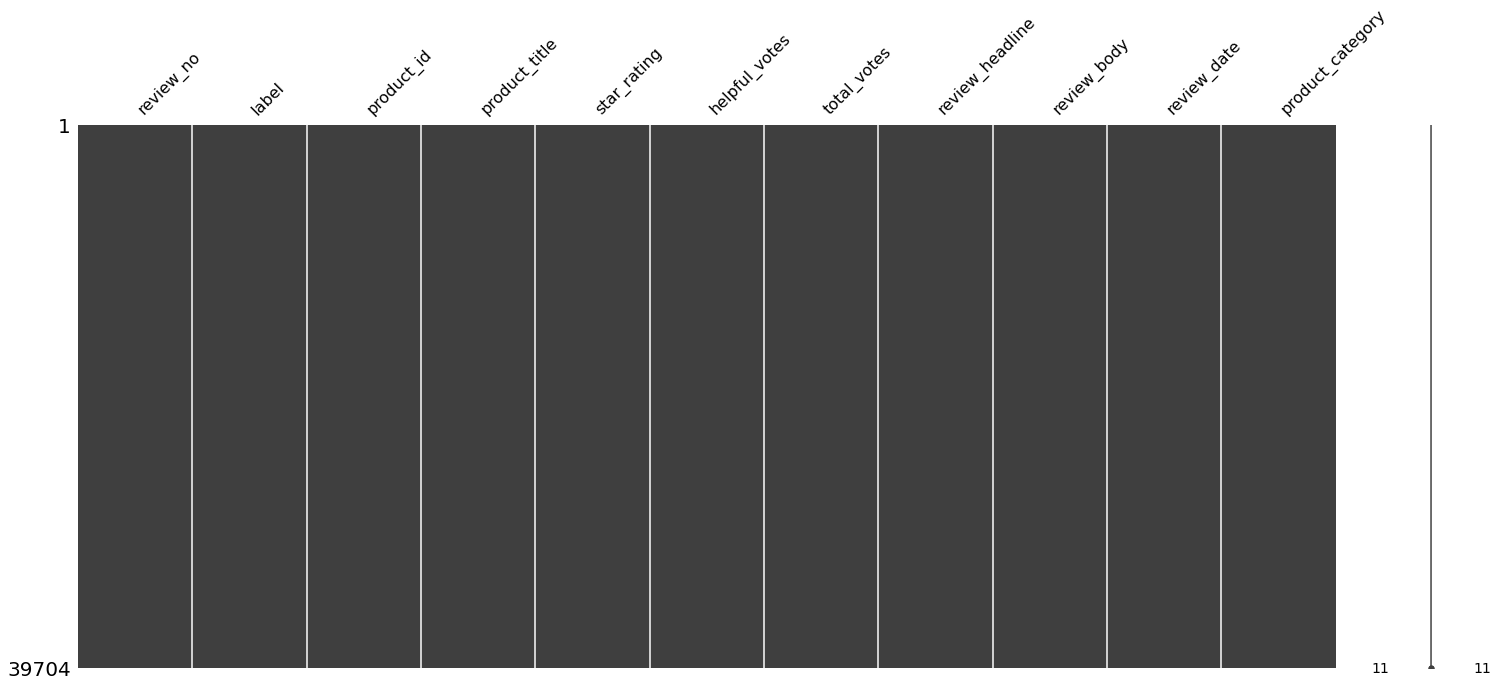

In [4]:
# Visualizing missingness of 'data_train.csv'
msno.matrix(review_data)

<AxesSubplot:>

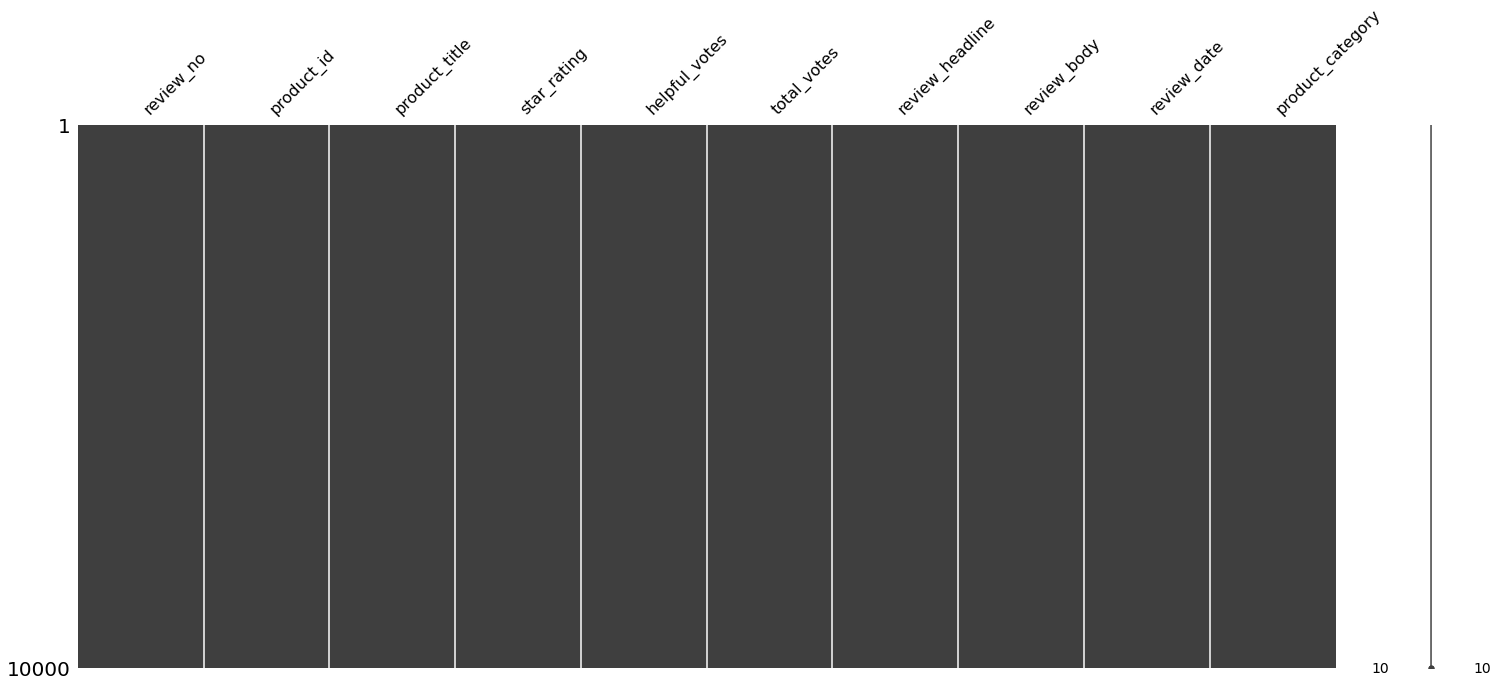

In [5]:
# Visualizing missingness of 'data_test.csv'
data_test = pd.read_csv('data_test.csv')
msno.matrix(data_test)

The train and test datasets are both very clean and do not contain any missing data points.
As such, no further handling of the dataframes for missing data is needed.

<a id="subsection-one-four"></a>
## 1.4 Text Preprocessing

Text may contain numbers, special characters, and unwanted spaces that will complicate the training of the model. Depending upon the problem we face, we may or may not need to remove these special characters and numbers from text. However, for the sake of this assignment, I will be removing all the special characters, numbers, and unwanted spaces from our text.

In [7]:
X

0        I am not exactly sure how to start this review...
1        Aside from its good performance, this Bluetoot...
2        I tried this for the very first time after try...
3        after i finished watching THE EAGLE from denma...
4        I have loved Rachel's previous novels but she ...
                               ...                        
39699    I've never been a big fan of rechargeable batt...
39700    I asked to review this for my godson who is 14...
39701    This Netgear AC1200 Wi-Fi Range Extender Works...
39702    I've had it about two weeks now and it's prett...
39703    I was listening to the radio a few fridays ago...
Name: review_body, Length: 39704, dtype: object

In [6]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In the script above I use Regex Expressions from Python re library to perform different preprocessing tasks. 

I started by removing all non-word characters such as special characters, numbers, etc.

Next, I remove all the single characters. For instance, when we remove the punctuation mark from "Sarah's" and replace it with a space, we get "Sarah" and a single character "s", which has no meaning. To remove such single characters I used \s+[a-zA-Z]\s+ regular expression which substitutes all the single characters having spaces on either side, with a single space.

Next, we use the \^[a-zA-Z]\s+ regular expression to replace a single character from the beginning of the document, with a single space. Replacing single characters with a single space may result in multiple spaces, which is not ideal.

We again use the regular expression \s+ to replace one or more spaces with a single space. When you have a dataset in bytes format, the alphabet letter "b" is appended before every string. The regex ^b\s+ removes "b" from the start of a string. The next step is to convert the data to lower case so that the words that are actually the same but have different cases can be treated equally.

The final preprocessing step is the lemmatization. In lemmatization, we reduce the word into dictionary root form. For instance "cats" is converted into "cat". Lemmatization is done in order to avoid creating features that are semantically similar but syntactically different. For instance, we don't want two different features named "cats" and "cat", which are semantically similar, therefore we perform lemmatization.

<a id="subsection-one-five"></a>
## 1.5 Converting review text into vectors

### Bag of Words

The following script uses the bag of words model to convert text documents into corresponding numerical features:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

The script above uses CountVectorizer class from the sklearn.feature_extraction.text library. There are some important parameters that are required to be passed to the constructor of the class. The first parameter is the max_features parameter, which is set to 1500. This is because when you convert words to numbers using the bag of words approach, all the unique words in all the documents are converted into features. All the documents can contain tens of thousands of unique words. But the words that have a very low frequency of occurrence are unusually not a good parameter for classifying documents. Therefore we set the max_features parameter to 1500, which means that we want to use 1500 most occurring words as features for training our classifier.

The next parameter is min_df and it has been set to 5. This corresponds to the minimum number of documents that should contain this feature. So we only include those words that occur in at least 5 documents. 

Similarly, for the max_df, feature the value is set to 0.7; in which the fraction corresponds to a percentage. Here 0.7 means that we should include only those words that occur in a maximum of 70% of all the documents. Words that occur in almost every document are usually not suitable for classification because they do not provide any unique information about the document. This can also be useful for other reasons. For example, there exists html texts such as <br/> which indicates a line break in the review. This appears in every single review and has no meaning. max_df will remove such cases.

Finally, we remove the stop words from our text since, in the case of sentiment analysis, stop words may not contain any useful information. To remove the stop words we pass the stopwords object from the nltk.corpus library to the stop_wordsparameter.

The fit_transform function of the CountVectorizer class converts text documents into corresponding numeric features.

### TFIDF

The bag of words approach works fine for converting text to numbers. However, it has one drawback. It assigns a score to a word based on its occurrence in a particular document. It doesn't take into account the fact that the word might also be having a high frequency of occurrence in other documents as well. TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency".

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

<a id="subsection-one-six"></a>
## 1.6 Train/Test Split

### Visualizing distribution of incentivized reviews in train dataset

Before splitting the data into train and test sets, I will first visualize the distribution of the classes in the dataset. This will allow me to better decide how to split the data for the train and test sets.

In [9]:
class_df = review_data.groupby('label').count()['review_no'].reset_index().sort_values(by='review_no',ascending=False)
class_df

,label,review_no
1,1,21048
0,0,18656


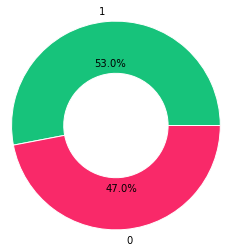

In [10]:
percent_class = class_df.review_no
labels = class_df.label
colors = ['#17C37B','#F92969']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2, labels = labels, colors = colors, autopct = "%.1f%%")

plt.setp(my_pie, width = 0.6, edgecolor = 'white') 

plt.show()

Since the distribution of classes is quite balanced, with 53% being incentivized and 47% otherwise, I will simply use train_test_split to split the data.

Should the classes have been unbalanced, I would have considered taking a stratified sample from the dataset in order to have better representation of my classes in the train and test sets.

### Splitting train and test data

Like any other supervised machine learning problem, we need to divide our data into training and testing sets. To do so, we will use the train_test_split utility from the sklearn.model_selection library. Execute the following script:

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<a id="section-two"></a>
# 2. MODEL TRAINING AND TESTING

We will train and test the following classification models:
1. Logistic Regression Classifier
2. Naive Bayes Classifier
3. Random Forest Classifier
4. Extreme Gradient Boosting (XGBoost) Classifier

<a id="subsection-two-one"></a>
## 2.1 Logistic Regression Classifier

First, I will be using a logistic regression Classifier from the sklearn.linear_model library.

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [13]:
y_pred_lr = lr.predict(X_test)

<a id="subsection-two-one"></a>
## 2.1 Naive Bayes Classifier

Second, I will be using the MultinomialNB model from the sklearn.naive_bayes library.

In [14]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [15]:
len(X_train)

31763

In [16]:
y_pred_mnb = mnb.predict(X_test)

<a id="subsection-two-three"></a>
## 2.3 Random Forest Classifier

Third, I will be using the Random Forest Classifier from the sklearn.ensemble library.

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [18]:
y_pred_rfc = rfc.predict(X_test)

<a id="subsection-two-four"></a>
## 2.4 Extreme Gradient Boosting (XGBoost) Classifier

Finally, I will be using the Extreme Gradient Boosting (XGBoost) Classifier from the xgboost library.

In [19]:
import xgboost as xgb

xgbc = xgb.XGBClassifier(n_estimators=1000, random_state=0)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_pred_xgbc = xgbc.predict(X_test)

<a id="section-three"></a>
# 3. MODEL EVALUATION

The above models will be evaluated on on their accuracy (precision, recall, F1-measure).

Further measures such as their confusion matrix, roc curve and auc will also be used.

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

<a id="subsection-three-one"></a>
## 3.1 ROC and AUC

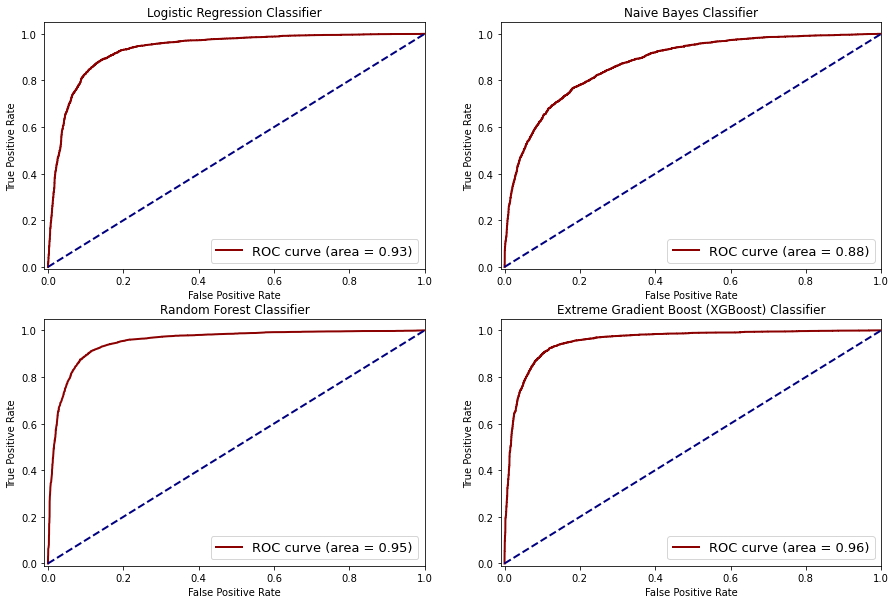

In [22]:
pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_mnb = mnb.predict_proba(X_test)[:, 1]
fpr_mnb,tpr_mnb,_ = roc_curve(y_test,pred_mnb)
roc_auc_mnb = auc(fpr_mnb,tpr_mnb)

pred_rfc = rfc.predict_proba(X_test)[:, 1]
fpr_rfc,tpr_rfc,_ = roc_curve(y_test,pred_rfc)
roc_auc_rfc = auc(fpr_rfc,tpr_rfc)

pred_xgbc = xgbc.predict_proba(X_test)[:, 1]
fpr_xgbc,tpr_xgbc,_ = roc_curve(y_test,pred_xgbc)
roc_auc_xgbc = auc(fpr_xgbc,tpr_xgbc)

f, axes = plt.subplots(2, 2,figsize=(15,10))

axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression Classifier')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_mnb,tpr_mnb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_mnb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes Classifier')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_rfc, tpr_rfc, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rfc))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_xgbc, tpr_xgbc, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xgbc))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Extreme Gradient Boost (XGBoost) Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);

I started my evaluation with ROC curve and AUC. As you may observe above, results look pretty good but it does not give much insight, except indicating the rough performance of each model. To decide which model is the best we must also examine other evaluation metrics.

<a id="subsection-three-one"></a>
## 3.1 Confusion Matrix

To reach more information, I also used confusion matrices. 

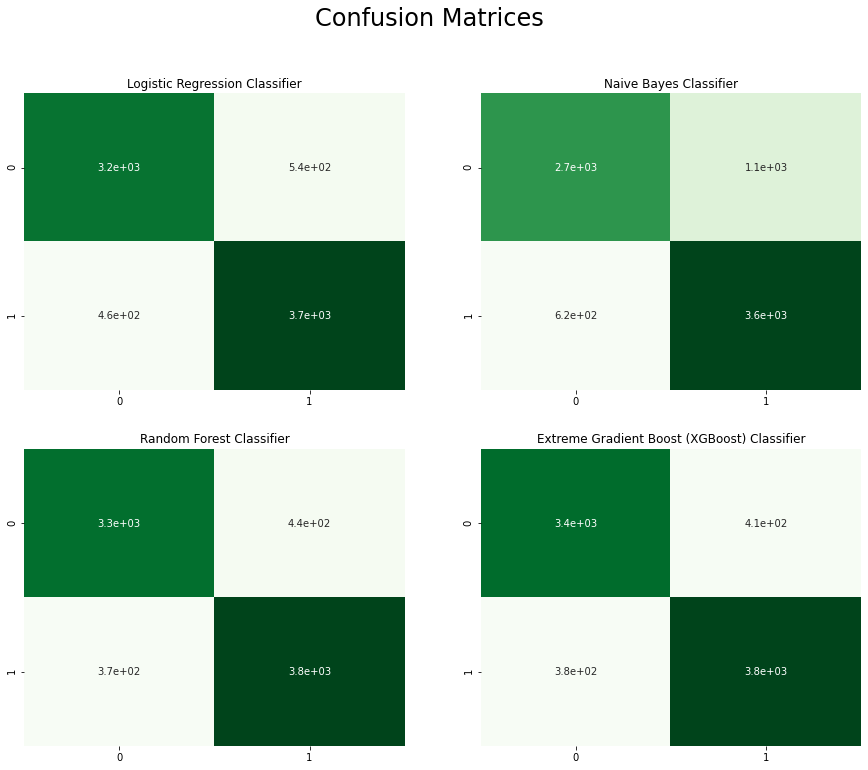

In [23]:
# preparation for the confusion matrix
lr_cm = confusion_matrix(y_test.values, y_pred_lr)
mnb_cm = confusion_matrix(y_test.values, y_pred_mnb)
rfc_cm = confusion_matrix(y_test.values, y_pred_rfc)
xgbc_cm = confusion_matrix(y_test.values, y_pred_xgbc)

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression Classifier")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,2)
plt.title("Naive Bayes Classifier")
sns.heatmap(mnb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,3)
plt.title("Random Forest Classifier")
sns.heatmap(rfc_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,4)
plt.title("Extreme Gradient Boost (XGBoost) Classifier")
sns.heatmap(xgbc_cm, annot = True, cmap="Greens",cbar=False);

From the above confusion matrices, we get a better look at why some models are performing better than others.

The naive bayes classifier performs the worst with the highest false positive and false negative predictions.

Next up is the logistic regression classifier which predicts significantly less false positives and false negatives compared to the naive bayes classifier. 

The random forest and extreme gradient boost (XGBoost) classifiers have the lowest false positive and false negative values which are quite similar. While the random forest classifier has slightly less false negative predictions, the XGBoost model has less false positive predictions. This feature might be useful in different applications and both models are shown to be good performers.

<a id="subsection-three-three"></a>
## 3.2 Classification reports and accuracy score

In [24]:
print("\n\n Logistic Regression Classifier")
print(classification_report(y_test, y_pred_lr))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr)))

print("Naive Bayes Classifier")
print(classification_report(y_test, y_pred_mnb))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_mnb)))

print("\n\n Random Forest Classifier")
print(classification_report(y_test, y_pred_rfc))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_rfc)))

print("\n\n Extreme Gradient Boost (XGBoost) Classifier")
print(classification_report(y_test, y_pred_xgbc))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_xgbc)))



 Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3771
           1       0.87      0.89      0.88      4170

    accuracy                           0.87      7941
   macro avg       0.87      0.87      0.87      7941
weighted avg       0.87      0.87      0.87      7941

Accuracy: 0.8735675607606095
Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      3771
           1       0.77      0.85      0.81      4170

    accuracy                           0.79      7941
   macro avg       0.79      0.78      0.78      7941
weighted avg       0.79      0.79      0.79      7941

Accuracy: 0.7873063845863242


 Random Forest Classifier
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3771
           1       0.90      0.91      0.90      4170

    accuracy                           

<a id="subsection-three-four"></a>
## 3.4 Model evaluation and Conclusion

When we look at the results of the all evaluation metrics in the evaluating models section, Random Forest and XGBoost gives the best results for our analysis with around 90% accuracy, with high f-scores. Thus, both of them are very effective at predicting incentivised reviews. 

On the other hand, it seems that logistic regression takes less time with still avert decent accuracy scores at 87% and f1-score around 87%. When we have a bigger dataset, the less time it take for the model to run might be an important advantage. 

The Naive Bayes model produces the worst results. Although in reality an accuracy score of 79% is decent, it will not be considered for this exercise.

However, since the XGBoost model seems to be the best performing model for this assignment, I will be using it to predict if the reviews from "data_test.csv" are incentivised or otherwise.

<a id="section-four"></a>
# 4. SAVING THE MODEL AND EXECUTING PREDICTION ON "data_test.csv"

<a id="subsection-four-one"></a>
## 4.1 Saving our model as a pickle object in Python

In the above scripts, my machine learning models took close to an hour to execute. This is because the size of the data is relatively large and each review consists of many words.

However, in real-world scenarios, there can be millions of documents each containing many words and topics. In such cases, it can take hours or even days (if you have slower machines) to train the algorithms. Therefore, it is recommended to save the model once it is trained.

I have save my model as a pickle object in Python. To do so, I executed the following script:

In [25]:
with open('xgbc_classifier', 'wb') as picklefile:
    pickle.dump(xgbc,picklefile)

<a id="subsection-four-two"></a>
## 4.2 Importing, pre-processing  and vectorizing review text from "data_test.csv"

I imported 'data_test.csv' and ran the review body through same pre-processing and vectorization as earlier

In [26]:
result_test = pd.read_csv("data_test.csv")
X_result_test = result_test.review_body
X_result_test.head()

0    Season Five got off to a stunning start. We pi...
1    I loved the clean that I received when using t...
2    Radiomen might be the builders of crystal sets...
3    I just got this for a gift. The baby is not he...
4    Lorilyn Roberts has written an adorable childr...
Name: review_body, dtype: object

In [27]:
documents_test = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X_result_test)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_result_test[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents_test.append(document)

In [28]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_result_test = vectorizer.fit_transform(documents_test).toarray()

In [29]:
tfidfconverter = TfidfTransformer()
X_result_test = tfidfconverter.fit_transform(X_result_test).toarray()

<a id="subsection-four-three"></a>
## 4.3 Loading and executing the previously saved XGBoost model

In the previous segment, I saved the XGBoost model as the file 'xgbc_classifier' in my working directory. In doing so, I saved the trained model for use in directly making predictions, without training.

To load the model, I used the following code:

In [32]:
with open('xgbc_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

I then executed the code on the target of my prediction.

In [33]:
result_pred_xgbc = model.predict(X_result_test)

<a id="subsection-four-four"></a>
## 4.4 Saving the labelled test data for submission

Finally I will merge the 'review_no' from 'data_test.csv' to the predictions made from my model for submission.

In [38]:
sub_result_test = pd.read_csv("data_test.csv", usecols = ['review_no'])
temp_pred = pd.DataFrame(xgbc.predict(X_result_test))

In [39]:
sub_result_test['label'] = temp_pred

In [41]:
sub_result_test.groupby(['label']).count()

,review_no
label,
0,9274
1,726


In [43]:
sub_result_test.to_csv('A0168236Y_result_test.csv', index=False)